In [7]:
import os
import argparse
import json
import torch
import torch.utils.data as data
import pytorch_lightning as pl 
from pytorch_lightning.callbacks import ModelCheckpoint
from shutil import copyfile
import numpy as np

import sys
sys.path.append('../')
from experiments.datasets import VoronoiDataset, CausalWorldDataset, iTHORDataset

data_dir = '/home/john/PhD/BISCUIT/data_generation/data/ithor/train/'
data = np.load(data_dir + 'train_seq_3293867794.npz')

In [16]:
data['collected_descriptions']

array(['NoOp NoObject3', 'NoOp NoObject3', 'OpenObject Microwave',
       'ToggleObject Toaster', 'OpenObject Cabinet_47fc321b',
       'ToggleObject StoveKnob_38c1dbc2',
       'ToggleObject StoveKnob_38c1dbc2', 'PickupObject Plate',
       'PutObject CounterTop_f8092513', 'PickupObject Plate',
       'OpenObject Microwave', 'PutObject CounterTop_f8092513',
       'OpenObject Cabinet_47fc321b', 'PickupObject Egg',
       'ToggleObject StoveKnob_c8955f66', 'MoveObject Plate',
       'ToggleObject Microwave', 'PutObject CounterTop_f8092513',
       'PickupObject Plate', 'PutObject CounterTop_f8092513',
       'OpenObject Cabinet_47fc321b', 'ToggleObject StoveKnob_690d0d5d',
       'NoOp NoObject2', 'NoOp NoObject1',
       'ToggleObject StoveKnob_690d0d5d', 'PickupObject Plate',
       'PutObject CounterTop_f8092513', 'OpenObject Cabinet_47fc321b',
       'PickupObject Egg', 'MoveObject Plate',
       'PutObject CounterTop_f8092513', 'ToggleObject StoveKnob_c8955f66',
       'PickupObje

In [1]:
def get_default_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='/home/john/Sync/BISCUIT/data/ithor_subsampled/')
    parser.add_argument('--cluster', action="store_true")
    parser.add_argument('--seed', type=int, default=42)
    parser.add_argument('--max_epochs', type=int, default=200)
    parser.add_argument('--debug', action='store_true')
    parser.add_argument('--offline', action='store_true')
    parser.add_argument('--batch_size', type=int, default=128)
    parser.add_argument('--num_workers', type=int, default=4)
    parser.add_argument('--data_img_width', type=int, default=-1)
    parser.add_argument('--seq_len', type=int, default=2)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--warmup', type=int, default=100)
    parser.add_argument('--check_val_every_n_epoch', type=int, default=-1)
    parser.add_argument('--logger_name', type=str, default='')
    parser.add_argument('--files_to_save', type=str, nargs='+', default='')
    parser.add_argument('--compile', action='store_true')
    return parser

def load_datasets(args):
    pl.seed_everything(args.seed)
    print('Loading datasets...')
    if 'voronoi' in args.data_dir:
        data_name = 'voronoi' + args.data_dir.split('voronoi')[-1].replace('/','')
        DataClass = VoronoiDataset
        dataset_args = {'return_targets': False, 'return_robot_state': True}
    elif 'causal_world' in args.data_dir:
        data_name = 'causalworld' + args.data_dir.split('causal_world')[-1].replace('/','')
        DataClass = CausalWorldDataset
        dataset_args = {'downsample_images': True}
    elif 'ithor' in args.data_dir:
        data_name = 'ithor' + args.data_dir.split('ithor')[-1].replace('/','')
        DataClass = iTHORDataset
        dataset_args = {}
    else:
        assert False, f'Unknown data class for {args.data_dir}'
    if hasattr(args, 'try_encodings'):
        dataset_args['try_encodings'] = args.try_encodings
    train_dataset = DataClass(
        data_folder=args.data_dir, split='train', single_image=False, triplet=False, seq_len=args.seq_len, cluster=args.cluster, return_text=True, **dataset_args)
    val_dataset = DataClass(
        data_folder=args.data_dir, split='val_indep', single_image=True, triplet=False, return_latents=True, cluster=args.cluster, return_text=True, **dataset_args)
    val_seq_dataset = DataClass(
        data_folder=args.data_dir, split='val', single_image=False, triplet=False, seq_len=args.seq_len, cluster=args.cluster, return_text=True, **dataset_args)
    test_dataset = DataClass(
        data_folder=args.data_dir, split='test_indep', single_image=True, triplet=False, return_latents=True, cluster=args.cluster, return_text=True, **dataset_args)
    test_seq_dataset = DataClass(
        data_folder=args.data_dir, split='test', single_image=False, triplet=False, seq_len=args.seq_len, cluster=args.cluster, return_text=True, **dataset_args)
    train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size,
                                   shuffle=True, pin_memory=True, drop_last=True, num_workers=args.num_workers)
    val_seq_loader = data.DataLoader(val_seq_dataset, batch_size=args.batch_size,
                                  shuffle=False, drop_last=False, num_workers=args.num_workers)
    test_seq_loader = data.DataLoader(test_seq_dataset, batch_size=args.batch_size,
                                  shuffle=False, drop_last=False, num_workers=args.num_workers)

    print(f'Training dataset size: {len(train_dataset)} / {len(train_loader)}')
    print(f'Val sequence dataset size: {len(val_seq_dataset)} / {len(val_seq_loader)}')
    if isinstance(val_dataset, dict):
        print(f'Val correlation dataset sizes: { {key: len(val_dataset[key]) for key in val_dataset} }')
    else:
        print(f'Val correlation dataset size: {len(val_dataset)}')
    print(f'Test sequence dataset size: {len(test_seq_dataset)} / {len(test_seq_loader)}')
    if isinstance(test_dataset, dict):
        print(f'Test correlation dataset sizes: { {key: len(test_dataset[key]) for key in test_dataset} }')
    else:
        print(f'Test correlation dataset size: {len(test_dataset)}')

    datasets = {
        'train': train_dataset,
        'val': val_dataset,
        'val_seq': val_seq_dataset,
        'test': test_dataset,
        'test_seq': test_seq_dataset
    }
    data_loaders = {
        'train': train_loader,
        'val_seq': val_seq_loader,
        'test_seq': test_seq_loader
    }

    if hasattr(datasets['train'], 'action_size'):
        for key in ['return_robot_state', 'return_targets']:
            if key in dataset_args:
                dataset_args.pop(key)
        action_dataset = DataClass(data_folder=args.data_dir,
                                   split='val',
                                   return_robot_state=True,
                                   triplet=False,
                                   return_targets=True,
                                   **dataset_args
                                   )
        action_loader = data.DataLoader(action_dataset,
                                        batch_size=args.batch_size,
                                        shuffle=False)
        datasets['action'] = action_dataset
        data_loaders['action'] = action_loader

    return datasets, data_loaders, data_name

In [9]:
# Fake args
args = get_default_parser().parse_args([])
datasets, data_loaders, data_name = load_datasets(args)

Global seed set to 42


Loading datasets...


Loading sequences of train:   0%|          | 0/150 [00:00<?, ?it/s]

tensor(-1.8750) tensor(0.6250)
Ignoring for now...
tensor(-2.8000) tensor(0.2003)
Ignoring for now...
tensor(-0.8312) tensor(1.6000)
Ignoring for now...
tensor(-2.1429) tensor(0.7949)
Ignoring for now...
tensor(-2.8000) tensor(0.7834)
Ignoring for now...
tensor(-0.8889) tensor(1.6667)
Ignoring for now...


Loading sequences of val_indep:   0%|          | 0/15 [00:00<?, ?it/s]

Loading sequences of val:   0%|          | 0/30 [00:00<?, ?it/s]

tensor(-1.8750) tensor(0.6250)
Ignoring for now...
tensor(-2.8000) tensor(0.2003)
Ignoring for now...
tensor(-0.8312) tensor(1.6000)
Ignoring for now...
tensor(-2.1429) tensor(0.7949)
Ignoring for now...
tensor(-2.8000) tensor(0.7833)
Ignoring for now...
tensor(-0.8889) tensor(1.6667)
Ignoring for now...


Loading sequences of test_indep:   0%|          | 0/15 [00:00<?, ?it/s]

Loading sequences of test:   0%|          | 0/30 [00:00<?, ?it/s]

Training dataset size: 14850 / 116
Val sequence dataset size: 2970 / 24
Val correlation dataset size: 1500
Test sequence dataset size: 2970 / 24
Test correlation dataset size: 1500


Loading sequences of val:   0%|          | 0/30 [00:00<?, ?it/s]

tensor(-1.8750) tensor(0.6250)
Ignoring for now...
tensor(-2.8000) tensor(0.2003)
Ignoring for now...
tensor(-0.8312) tensor(1.6000)
Ignoring for now...
tensor(-2.1429) tensor(0.7949)
Ignoring for now...
tensor(-2.8000) tensor(0.7833)
Ignoring for now...
tensor(-0.8889) tensor(1.6667)
Ignoring for now...


In [19]:
datasets['train'].action_size()

2

In [17]:
datasets['val_seq'][2]

(tensor([[[[-0.1451, -0.1216, -0.1059,  ..., -0.0353, -0.0275, -0.0353],
           [-0.1137, -0.1451, -0.1373,  ..., -0.0275, -0.0118, -0.0196],
           [-0.1059, -0.0980, -0.1137,  ..., -0.0118, -0.0118, -0.0039],
           ...,
           [ 0.2000,  0.1137,  0.2000,  ..., -0.5216, -0.5216, -0.5216],
           [ 0.1529,  0.1216,  0.2078,  ..., -0.4039, -0.4039, -0.4039],
           [ 0.2157,  0.1686,  0.1922,  ..., -0.4039, -0.4039, -0.4039]],
 
          [[-0.5059, -0.4824, -0.4667,  ..., -0.4275, -0.4196, -0.4275],
           [-0.4745, -0.4980, -0.4980,  ..., -0.4275, -0.4275, -0.4196],
           [-0.4745, -0.4667, -0.4745,  ..., -0.4196, -0.4196, -0.4039],
           ...,
           [ 0.1059,  0.0118,  0.1059,  ..., -0.5059, -0.5137, -0.5137],
           [ 0.0588,  0.0275,  0.1137,  ..., -0.3882, -0.3882, -0.3882],
           [ 0.1137,  0.0745,  0.0980,  ..., -0.3882, -0.3882, -0.3882]],
 
          [[-0.6784, -0.6549, -0.6314,  ..., -0.6000, -0.5922, -0.5922],
           [-

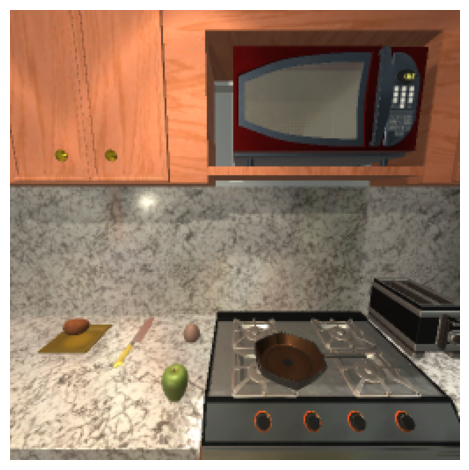

In [16]:
import numpy as np
import matplotlib.pyplot as plt

a = np.load('trainseq_3439027337.npz')
plt.imshow(a['frames'][0].transpose(1,2,0))
# Remove axes
plt.axis('off')
# Remove whitespace
plt.tight_layout()
plt.show()

In [14]:
!scp gkounto@snellius.surf.nl:/scratch-shared/gkounto/biscuit/data/ithor_extended/train/trainseq_3439027337.npz .

trainseq_3439027337.npz                       100%   15MB  10.3MB/s   00:01    
